<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
<h1> This notebook introduces you to decoding using Allen Brain Observatory data </h1>
    
A tuning curve summarizes a neuron's response to stimulus categories. Here we will look at the responses of a neuron to the 'Drifting Gratings' stimulus.

The Drifting Gratings stimulus consists of a sinusoidal grating that moves in 8 directions and at 5 temporal frequencies. Each stimulus condition (direction + temporal frequency combination) is repeated 15 times in random order. In addition, there are blanksweeps (when the grating is replaced with mean luminance gray) interleaved among the trials.

We will compute the mean response of a neuron to each of these stimulus conditions.
</div>

In [1]:
# @title Run to initialize Allen Brain Observatory on Colab {display-mode: "form" }
# run only once per runtime/session, and only if running in colab
# the runtime will need to restart after
%%capture
!apt install s3fs
!pip install allensdk
!mkdir -p /data/allen-brain-observatory/
!s3fs allen-brain-observatory /data/allen-brain-observatory/ -o public_bucket=1

### Standard imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# we're going to need lists of colors below
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS.values())

In [3]:
import sklearn

### Allen Brain Observatory set up

This instantiates the tools in the Allen SDK that allow us to access the Brain Observatory data.

In [4]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = '/data/allen-brain-observatory/visual-coding-2p/manifest.json'
boc = BrainObservatoryCache(manifest_file=manifest_file)

We'll look at one cell to start

In [5]:
session_id = 540684467


In [6]:
cell_id = 541513979

In [7]:
exps = boc.get_ophys_experiments(cell_specimen_ids=[541513979], stimuli=['drifting_gratings'])

In [8]:
data_set = boc.get_ophys_experiment_data(session_id)

In [9]:
cell_index = data_set.get_cell_specimen_indices([cell_id])[0]

<p>In order to compute the tuning curve of the neuron, we need to access

<li>the activity of the neuron.  We will use the DF/F trace
<li>stimulus information for the drifting grating stimulus

<p>We have written the function below that uses the AllenSDK to get these pieces of data. It does so by first identifying which experiment session contains the specified cell id and stimulus. It then accesses the NWB file for that session and reads the DF/F trace for the specified cell and the stimulus table for the specified stimulus.

In [10]:
exps

[{'id': 540684467,
  'imaging_depth': 175,
  'targeted_structure': 'VISp',
  'cre_line': 'Emx1-IRES-Cre',
  'reporter_line': 'Ai93(TITL-GCaMP6f)',
  'acquisition_age_days': 120,
  'experiment_container_id': 536323956,
  'session_type': 'three_session_A',
  'donor_name': '252174',
  'specimen_name': 'Emx1-IRES-Cre;Camk2a-tTA;Ai93(MG)-252174',
  'fail_eye_tracking': False}]

In [11]:
def get_dff_traces_and_stim_table(session_id, stimulus):
    #identify the session for a given cell id and stimulus
    #exps = boc.get_ophys_experiments(cell_specimen_ids=[cell_specimen_id], stimuli=[stimulus])

    #get the session_id for that session
    #session_id = exps[0]['id']

    #access the data for that session
    data_set = boc.get_ophys_experiment_data(session_id)

    #get the DFF trace for the cell
    timestamps, dff = data_set.get_dff_traces()
    # dff_trace = dff[0,:]

    #get the stimulus table for the stimulus
    stim_table = data_set.get_stimulus_table(stimulus)

    #return everything
    return (timestamps, dff, stim_table)

In [12]:
timestamps, dff, stim_table = get_dff_traces_and_stim_table(session_id, 'drifting_gratings')

It is always good to look at the data objects you're working with to make sure you understand what they are. What is the shape of the dff array?

In [13]:
dff.shape

(290, 115741)

In [14]:
num_neurons = dff.shape[0]

We need to create a **design matrix** for decoding.  This is a matrix of shape [trials, dimension].  In this case 'dimension' is the number of neurons we are going to use for decoding.  We will need to iterate through the `stim_table` to compute this.

As we saw last time, the `stim_table` looks like this:

In [15]:
stim_table.head(n=10)

,temporal_frequency,orientation,blank_sweep,start,end
0,1.0,45.0,0.0,736,796
1,15.0,90.0,0.0,826,886
2,1.0,270.0,0.0,917,977
3,NaN,NaN,1.0,1007,1067
4,4.0,90.0,0.0,1098,1158
5,1.0,270.0,0.0,1188,1248
6,2.0,135.0,0.0,1279,1339
7,4.0,270.0,0.0,1370,1429
8,4.0,45.0,0.0,1460,1520
9,4.0,0.0,0.0,1551,1610


For each presentation, we will need to compute the response from `start` to `end`.  Now we are doing this for every neuron in the data set simultaneously.

<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
**Quick pandas tutorial for our purposes today!**
(This is reproduced from our last notebook in case you need a refresher!)

To access data from a DataFrame we must specify the column we are using and specify the row using the index. To specify a column we can use two methods:

```stim_table['start']```

```stim_table.start```

Then to specify the row we want we must use the index of that row:

```stim_table['start'][0]```

```stim_table.start[0]```

We can also subselect portions of the DataFrame using the values in the DataFrame. For example, to select only the rows of the table where the orientation is 90 degrees we can use:

```stim_table[stim_table.orientation==90]```

Try this yourself. Note the index. The rows of this subselected DataFrame maintain the indices of the original DataFrame. Now in order to get a specific row, you either need to know it's original index, or use iloc. For example, this will return the first row of the subselected DataFrame regardless of the original index of that row:

```stim_table[stim_table.orientation==90].iloc[0]```
</div>

In [16]:
num_trials = stim_table.shape[0]
activity = np.zeros([num_trials, num_neurons])
stim = [] #np.zeros(num_trials)
for i, row in stim_table.iterrows():
  activity[i] = dff[:,int(row.start):int(row.end)].mean(axis=1) # only compute the mean for each neuron
  #stim[i] = row.orientation
  if np.isfinite(row.orientation):
    stim.append(str(row.orientation))
  else:
    stim.append('blank')

stim = np.array(stim)

Let's compute all the tuning curves quickly.

(This is essentially the same computation we did last time don't slightly differently, and for all the neurons simultaneously.)

In [17]:
orientations = np.sort(stim_table.orientation.unique())
orientation_labels = [str(ori) for ori in orientations[:-1]] + ['blank']
num_orientations = len(orientations)
tuning_curves = np.zeros([num_neurons, num_orientations-1])

for i, ori in enumerate(orientations[:-1]):  # leave out nans
  mask = stim==str(ori)
  tuning_curves[:,i] = activity[mask,:].mean(axis=0)

**Exercise 1**:  Add another array to keep track of temporal frequency and compute the temporal frequency tuning curves.

In [40]:
cell_index = 6   # This is the cell we looked at last time!

As a sanity check, let's take a look at the tuning curve for the cell we analyzed last time.

([<matplotlib.axis.XTick at 0x7f4759dc9890>,
 [Text(0.0, 0, '0'),
  Text(45.0, 0, '45'),
  Text(90.0, 0, '90'),
  Text(135.0, 0, '135'),
  Text(180.0, 0, '180'),
  Text(225.0, 0, '225'),
  Text(270.0, 0, '270'),
  Text(315.0, 0, '315')])

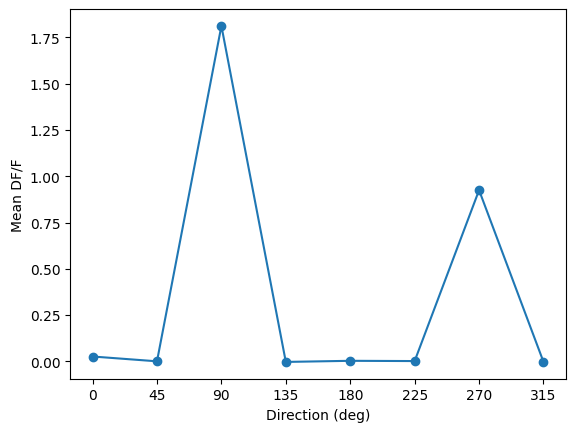

In [41]:
plt.plot(orientations[:-1], tuning_curves[cell_index],'o-')
plt.xlabel("Direction (deg)")
plt.ylabel("Mean DF/F")
plt.xticks(orientations[:-1])

**Exercise 2**:  Find another cell that responds well to this stimulus.

(Hint:  look at the maximum response for each neuron.)

In [43]:
cell_index2 = 228

([<matplotlib.axis.XTick at 0x7f4759c3e690>,
 [Text(0.0, 0, '0'),
  Text(45.0, 0, '45'),
  Text(90.0, 0, '90'),
  Text(135.0, 0, '135'),
  Text(180.0, 0, '180'),
  Text(225.0, 0, '225'),
  Text(270.0, 0, '270'),
  Text(315.0, 0, '315')])

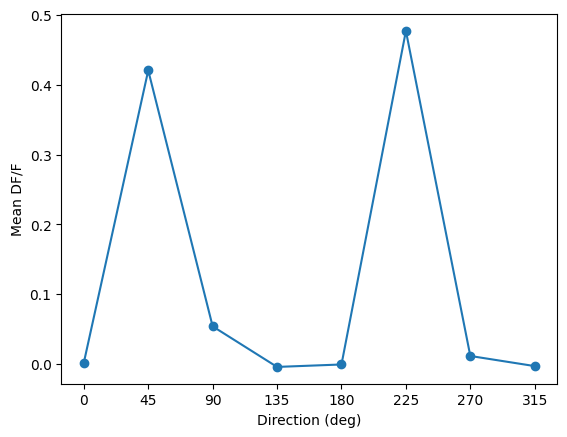

In [42]:
plt.plot(orientations[:-1], tuning_curves[cell_index2],'o-')
plt.xlabel("Direction (deg)")
plt.ylabel("Mean DF/F")
plt.xticks(orientations[:-1]) # 9

In [20]:
two_neuron_activity = activity[:,[cell_index,cell_index2]]

Text(0, 0.5, 'cell index 228')

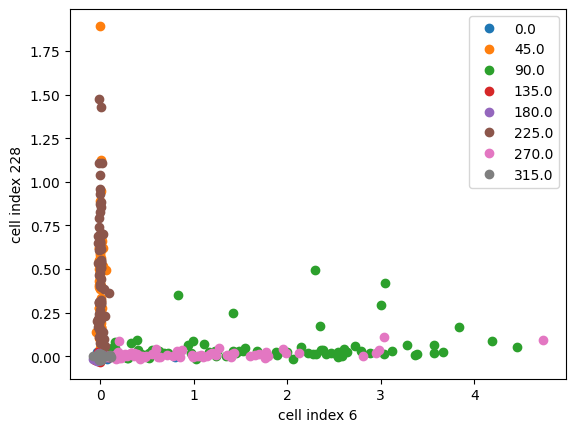

In [21]:
for i, ori in enumerate(orientations[:-1]):
  mask = stim==str(ori)
  plt.plot(two_neuron_activity[mask,0], two_neuron_activity[mask,1],'o',color=colors[i], label=ori)
  plt.legend()
plt.xlabel('cell index '+str(cell_index))
plt.ylabel('cell index '+str(cell_index2))

**Exercise 3**: Plot the temporal frequency tuning curves for these two cells.  Make a similar scatter plot of the trials of the two neurons with temporal frequency.

In order to test our decoding models, we will need to set aside some data from testing, and use the rest for training.  (Why?)

For now, we are going to do this in a simple way, taking advantage of the fact that the stimulus presentations were randomized.  We will use the last quarter of the data for testing.

In [22]:
test_index = int(0.75*num_trials)

two_neuron_activity_test = two_neuron_activity[test_index:]
two_neuron_activity_train = two_neuron_activity[:test_index]

stim_test = stim[test_index:]
stim_train = stim[:test_index]

(two_neuron_activity_test.shape, stim_test.shape), (two_neuron_activity_train.shape, stim_train.shape)

(((157, 2), (157,)), ((471, 2), (471,)))

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

classifier = LDA()
classifier.fit(two_neuron_activity_train, stim_train)

LinearDiscriminantAnalysis()

How well did we do?

In [24]:
stim_train_hat2 = classifier.predict(two_neuron_activity_train)
stim_test_hat2 = classifier.predict(two_neuron_activity_test)

In [25]:
print("Percentage correct on training set:  ", np.mean(stim_train_hat2 == stim_train))

print("Percentage correct on testing set:  ", np.mean(stim_test_hat2 == stim_test))

Percentage correct on training set:   0.3333333333333333
Percentage correct on testing set:   0.2929936305732484


Only 30%!  

On one hand, the fact that the test and train performance are so close is a good sign.  It means the model has not *overfit*.

What's going on?  Let's plot where the decoder got it right and where is made mistakes.

In [26]:
def plot_test_performance(X, y, y_hat, xlabel=None, ylabel = None, names = None, ax = None):

    classes = np.unique(y)
    num_classes = len(classes)

    if ax is None:
        ax = plt.figure(figsize=(8,8)).gca()

    for ii,cl in enumerate(classes):
        if names is not None: # If 'names' was passed, use this for label
            this_label = names[ii]
        else:
            this_label = f'Class {cl}' # If 'names' was passed, otherwise use class number

        # Determine which points were correct (or not)
        is_class = y == cl
        is_correct = y == y_hat

        # Plot correctness with labels
        ax.scatter(X[is_class & is_correct,0],X[is_class & is_correct,1],c=colors[ii],edgecolor='none',label = this_label + ' correct')
        ax.scatter(X[is_class & ~is_correct,0],X[is_class & ~is_correct,1],c='none',edgecolor=colors[ii],label =this_label + ' incorrect')

    ax.set_xlim(X[:,0].min(),X[:,0].max())
    ax.set_ylim(X[:,1].min(),X[:,1].max())
    ax.set_xlabel(xlabel)# Optionally label axes
    ax.set_ylabel(ylabel)# Optionally label axes
    ax.legend()
    plt.show()
    return ax

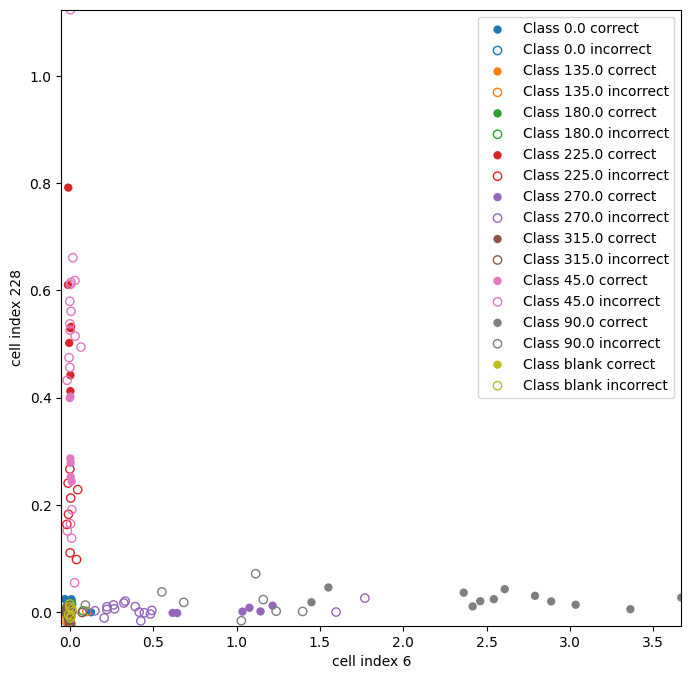

<Axes: xlabel='cell index 6', ylabel='cell index 228'>

In [27]:
plot_test_performance(two_neuron_activity_test, stim_test, stim_test_hat2, xlabel='cell index '+str(cell_index), ylabel='cell index '+str(cell_index2))

**Exercise 4**: Train a classifier to decode the temporal frequency of each trial and make a plot of the test performance.

In [28]:
from sklearn.metrics import confusion_matrix

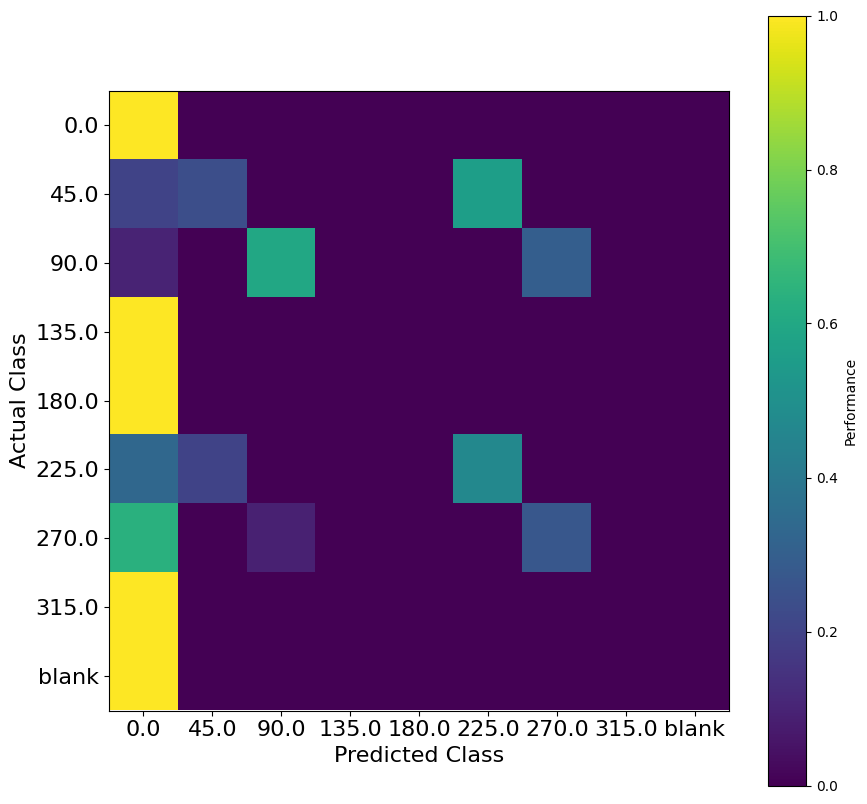

In [29]:


C = confusion_matrix(stim_test, stim_test_hat2, normalize = 'true', labels=orientation_labels)
# Note that normalization is needed when all classes are not of the same size
# The default is to plot based on counts

classes = orientation_labels

plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
cax = ax.imshow(C,interpolation='none', vmin=0, vmax=C.max())

ax.set_xlabel('Predicted Class', fontsize=16)
ax.set_ylabel('Actual Class', fontsize=16)

ax.set_xticks(range(9))
ax.set_xticklabels(classes, fontsize=16)

ax.set_yticks(range(9))
ax.set_yticklabels(classes, fontsize=16)

cbar = plt.colorbar(cax)
cbar.set_label('Performance')

plt.show()

**Exercise 5**:  Plot the temporal frequency confusion matrix

The weights for the classifier are stored in a property called `coef_`.  Sadly, they are in arbitrary order so we have to do some rearranging to make them more interpretable.


In [30]:
weights = classifier.coef_
weights.shape

(9, 2)

In [31]:
classes = np.array([float(c) if c!='blank' else np.nan for c in classifier.classes_])
class_index = np.argsort(classes)
classes[class_index]

array([  0.,  45.,  90., 135., 180., 225., 270., 315.,  nan])

Text(0.5, 1.0, 'Tuning Curves')

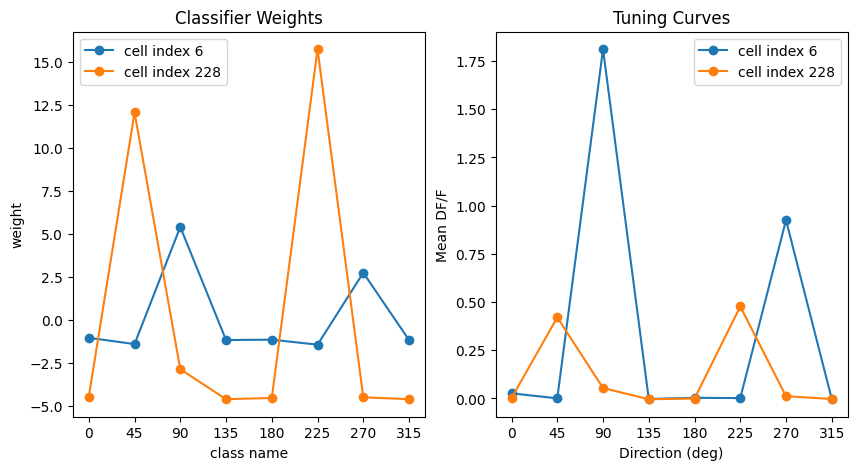

In [32]:

fix, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(classes[class_index[:-1]], weights[class_index[:-1],0], 'o-', label='cell index '+str(cell_index))
ax[0].plot(classes[class_index[:-1]], weights[class_index[:-1],1], 'o-', label='cell index '+str(cell_index2))
ax[0].set_xticks(classes[class_index[:-1]])
ax[0].legend()
ax[0].set_ylabel('weight')
ax[0].set_xlabel('class name')
ax[0].set_title('Classifier Weights')

ax[1].plot(orientations[:-1], tuning_curves[cell_index],'o-', label='cell index '+str(cell_index))
ax[1].plot(orientations[:-1], tuning_curves[cell_index2],'o-', label='cell index '+str(cell_index2))
ax[1].legend()
ax[1].set_xlabel("Direction (deg)")
ax[1].set_ylabel("Mean DF/F")
ax[1].set_xticks(orientations[:-1])
ax[1].set_title('Tuning Curves')

**Exercise 6**:  Plot the weights for the temporal frequency decoder.  Do they look similar to the tuning curves?

Can we do better with all of the neurons?

In [33]:
test_index = int(0.75*num_trials)

activity_test = activity[test_index:]
activity_train = activity[:test_index]

stim_test = stim[test_index:]
stim_train = stim[:test_index]

(activity_test.shape, stim_test.shape), (activity_train.shape, stim_train.shape)

(((157, 290), (157,)), ((471, 290), (471,)))

In [34]:
all_neuron_classifier = LDA()
all_neuron_classifier.fit(activity_train, stim_train)

LinearDiscriminantAnalysis()

In [35]:
stim_train_hat = all_neuron_classifier.predict(activity_train)
stim_test_hat = all_neuron_classifier.predict(activity_test)

In [36]:
print("Percentage correct on training set:  ", np.mean(stim_train_hat == stim_train))

print("Percentage correct on testing set:  ", np.mean(stim_test_hat == stim_test))

Percentage correct on training set:   1.0
Percentage correct on testing set:   0.6496815286624203


Wow!  This classifier is not *perfect* on the training set!  (Why?)

But it still makes mistakes on the test set.  Where are they happening?

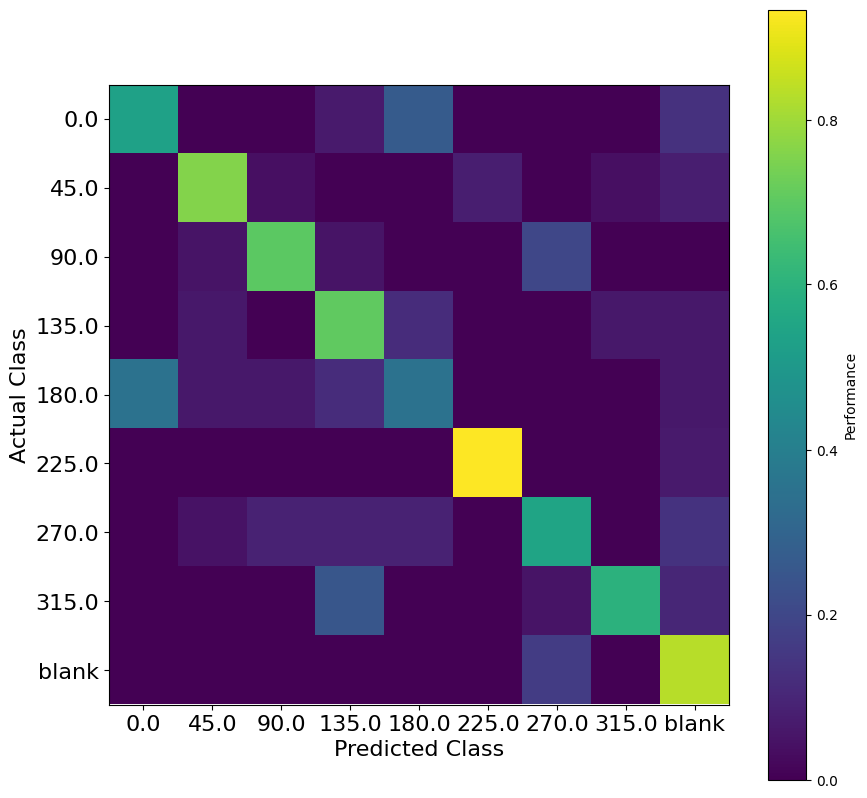

In [37]:

C = confusion_matrix(stim_test, stim_test_hat, normalize='true', labels=orientation_labels)
# Note that normalization is needed when all classes are not of the same size
# The default is to plot based on counts

classes = orientation_labels

plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
cax = ax.imshow(C,interpolation='none', vmin=0, vmax=C.max())

ax.set_xlabel('Predicted Class', fontsize=16)
ax.set_ylabel('Actual Class', fontsize=16)

ax.set_xticks(range(9))
ax.set_xticklabels(classes, fontsize=16)

ax.set_yticks(range(9))
ax.set_yticklabels(classes, fontsize=16)

cbar = plt.colorbar(cax)
cbar.set_label('Performance')

plt.show()

We see adding neurons provides more information to the classifier.  How many neurons do we need for good accuracy?

In [38]:
performance = np.zeros(num_neurons-2)

test_index = int(0.75*num_trials)
stim_test_n = stim[test_index:]
stim_train_n = stim[:test_index]

for n in range(2, num_neurons):
  neuron_indices = np.random.permutation(np.arange(num_neurons))[:n] # choose n random neurons

  activity_test_n = activity[test_index:, neuron_indices]
  activity_train_n = activity[:test_index, neuron_indices]

  n_classifier = LDA()
  n_classifier.fit(activity_train_n, stim_train_n)

  stim_test_hat_n = n_classifier.predict(activity_test_n)

  performance[n-2] = np.mean(stim_test_hat_n == stim_test_n)

Text(0.5, 0, 'number of neurons')

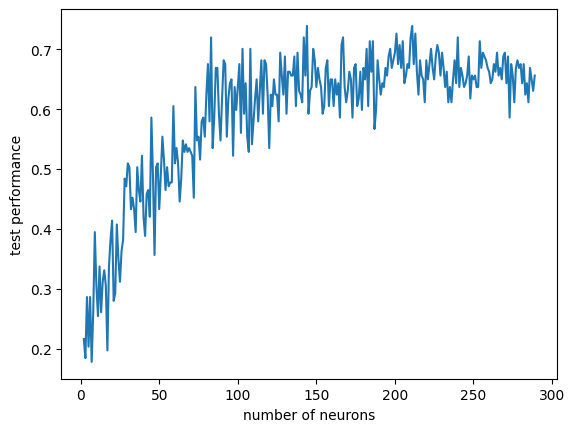

In [39]:
plt.plot(np.arange(2,num_neurons), performance)
plt.ylabel('test performance')
plt.xlabel('number of neurons')

**Exercise 7**:  Decode temporal frequency with all the neurons and plot the confusion matrix.  How does this performance increase with time?